# Train CNN-Model

This notebook will train our model based on pictures in our sorted_images folder and sub-folders.

In [1]:
#load the modules
import keras
import pickle
from keras import models, layers
from tensorflow.keras import regularizers
from keras.activations import relu, softmax
from tensorflow.keras.applications import VGG19
from keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Dense, Flatten, concatenate
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.preprocessing import OneHotEncoder

sys.modules['Image'] = Image

/Users/tobiasengbring/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# Keras' data generator can be used to pass the images through the convolutional neural network and apply
#rotation and zoom transformations to the images. Check https://keras.io/preprocessing/image/ for more transformations

train_data = ImageDataGenerator(
        rotation_range=40,
        zoom_range=0.2,
        rescale = 1./255)

train_generator = train_data.flow_from_directory(
        directory=r"../sorted_images/train",
        target_size=(224, 224),
        batch_size=1822,
        shuffle=False)

Found 1825 images belonging to 100 classes.


In [3]:
#defining the validation data generator
val_data = ImageDataGenerator(rescale = 1./255)
                                 
val_generator = val_data.flow_from_directory(
        directory=r"../sorted_images/val",
        target_size=(224, 224),
        batch_size=300,
        shuffle=False)

Found 300 images belonging to 100 classes.


## Getting dummies as arrays

In [4]:
train_data = pd.read_csv('../data/df_sorted_train.csv')
train_data = train_data["image_location"]
train_data_encoded = pd.get_dummies(train_data, columns=["image_location"])
train_data_array = np.array(train_data_encoded)

In [5]:
val_data = pd.read_csv('../data/df_sorted_val.csv')
val_data = val_data["image_location"]
val_data_encoded = pd.get_dummies(val_data, columns=["image_location"])
val_data_array = np.array(val_data_encoded)

In [6]:
#Same for test data
test_data = pd.read_csv('../data/df_sorted_test.csv')
test_data = test_data["image_location"]
test_data_encoded = pd.get_dummies(test_data, columns=["image_location"])
test_data_array = np.array(test_data_encoded)

In [7]:
#Getting arrays for the images and labels
x_train, y_train=next(train_generator)
x_val, y_val=next(val_generator)

In [8]:
y_train[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

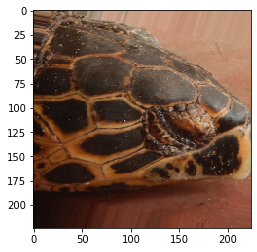

In [9]:
from matplotlib import pyplot as plt
plt.imshow(x_train[-1], interpolation='nearest')
plt.show()

### Getting Hog array

In [10]:
# load pickled train data
train_sorted_hog = open("../data/pickles/train_sorted_hog_2d.pickle","rb") #read binary
train_sorted_hog =  pickle.load(train_sorted_hog) #load pickle file

In [11]:
train_sorted_hog.shape

(1822, 224, 224)

In [12]:
validation_sorted_hog = open("../data/pickles/validation_sorted_hog_2d.pickle","rb") #read binary
validation_sorted_hog =  pickle.load(validation_sorted_hog) #load pickle file

In [13]:
validation_sorted_hog.shape

(300, 224, 224)

In [30]:
test_sorted_hog = open("../data/pickles/test_sorted_hog_2d.pickle","rb") #read binary
test_sorted_hog =  pickle.load(test_sorted_hog) #load pickle file

### Shuffle all arrays the same way

In [ ]:
from sklearn.utils import shuffle

x_val_shuffle=x_val
x_val_shuffle = shuffle(x_val_shuffle, random_state=0)

y_val_shuffle =y_val
y_val_shuffle = shuffle(y_val_shuffle, random_state=0)

x_train_shuffle =x_train
x_train_shuffle = shuffle(x_train_shuffle, random_state=0)

y_train_shuffle = y_train
y_train_shuffle = shuffle(y_train_shuffle, random_state=0)

train_data_array_shuffle = train_data_array
train_data_array_shuffle = shuffle(train_data_array_shuffle, random_state=0)

val_data_array_shuffle = val_data_array
val_data_array_shuffle = shuffle(val_data_array_shuffle, random_state=0)

test_data_array_shuffle = test_data_array
test_data_array_shuffle = shuffle(test_data_array_shuffle, random_state=0)

train_sorted_hog_shuffle = train_sorted_hog
train_sorted_hog_shuffle = shuffle(train_sorted_hog_shuffle, random_state=0)

validation_sorted_hog_shuffle = validation_sorted_hog
validation_sorted_hog_shuffle = shuffle(validation_sorted_hog_shuffle, random_state=0)

## MLP for classification data

In [14]:
MLP_model = Sequential()
MLP_model.add(Dense(8, input_dim=train_data_array.shape[1], activation="relu"))
MLP_model.add(Dense(8, activation="relu"))

Metal device set to: Apple M1


In [15]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________


## CNN Network for Image data

### VGG19

In [ ]:
#load the pre-trained VGG19 from keras
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in vgg19.layers:
    layer.trainable = False

cnn_model = vgg19.layers[-1].output
cnn_model = layers.Flatten()(cnn_model)

#add dropout and the fully connected layer
cnn_model = layers.Dropout(0.2)(cnn_model)
cnn_model = layers.Dense(1024, activation='relu')(cnn_model)

cnn_model = layers.Dense(1024, activation='relu')(cnn_model)

#cnn_model= MaxPooling2D(pool_size=(2, 2))(cnn_model)

cnn = Model(vgg19.input, cnn_model)

### Inception

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [17]:
inception = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

print(type(inception))
#the transfer learned model should be not trainable
for layer in inception.layers:
    layer.trainable = False

y = layers.Flatten()(inception.output)
y = layers.Dropout(0.2)(y)
y = layers.Dense(1024, activation='relu')(y) #, kernel_regularizer=regularizers.l2(0.00001)
y = layers.Dropout(0.2)(y)
y = layers.Dense(1024, activation='relu')(y) #, kernel_regularizer=regularizers.l2(0.00001)

inception_model = Model(inception.input, y)

<class 'keras.engine.functional.Functional'>


In [ ]:
#inception_model.summary()

from keras.layers import Input ### Hog_Array

### HOG

In [18]:
from keras.layers import Input 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Concatenate, Dropout

In [19]:
input_shape = Input(shape=(224,224,1))
z = Conv2D(3,(3,3), padding='same')(input_shape)  # x has a dimension of (IMG_SIZE,IMG_SIZE,3)

hog = VGG19(input_shape=(224,224,3), include_top = False, weights = 'imagenet')(z)

#the transfer learned model should be not trainable
hog.trainable = False
    
z = layers.Flatten()(hog)
z = layers.Dropout(0.2)(z)
z = layers.Dense(1024, activation='relu')(z) #, kernel_regularizer=regularizers.l2(0.00001)
z = layers.Dropout(0.2)(z)
z = layers.Dense(1024, activation='relu')(z) #, kernel_regularizer=regularizers.l2(0.00001)

hog_model = Model(inputs=input_shape, outputs=z)

In [ ]:
#hog_model.summary()

## Multi-input / Concatenation 

### Two-input concatenation

In [ ]:
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([MLP_model.output, inception_model.output])

combinedInput = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(combinedInput)
predictors = Dense(100, activation='softmax')(combinedInput)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
combined_model = Model(inputs=[MLP_model.input, inception_model.input], outputs=predictors)


### Three-input concatenation

In [20]:
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([MLP_model.output, inception_model.output, hog_model.output])

combinedInput = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(combinedInput)
predictors = Dense(100, activation='softmax')(combinedInput)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
combined_model = Model(inputs=[MLP_model.input, inception_model.input, hog_model.input], outputs=predictors)


In [ ]:
#combined_model.summary()

In [21]:
# Compile the model
combined_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5),#define the optimizer and the learning rate
              metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=5))

/Users/tobiasengbring/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# define where to save the model after each epoch
filepath = "../models/Saved_model_concatenation_vs2.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=10)
callbacks_list = [checkpoint, early_stopping_monitor]

In [23]:
#train the model
batch_size=64
model_history=combined_model.fit(
        [train_data_array, x_train, train_sorted_hog], y_train,
        steps_per_epoch=1822 //batch_size,#number of pictures in training data set divided by the batch size
        epochs=30,
        validation_data=([val_data_array, x_val, validation_sorted_hog], y_val),
        validation_steps= 300  // batch_size,#number of pictures in validation data set divided by the batch size
        callbacks=callbacks_list, shuffle=True)

2022-02-21 11:50:19.048100: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 4.6440 - top_k_categorical_accuracy: 0.1054
Epoch 00001: val_loss improved from inf to 4.74919, saving model to ../models/Saved_model_concatenation_vs2.h5
28/28 [==============================] - 239s 8s/step - loss: 4.6440 - top_k_categorical_accuracy: 0.1054 - val_loss: 4.7492 - val_top_k_categorical_accuracy: 0.0633
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 4.4603 - top_k_categorical_accuracy: 0.1701
Epoch 00002: val_loss did not improve from 4.74919
28/28 [==============================] - 271s 10s/step - loss: 4.4603 - top_k_categorical_accuracy: 0.1701 - val_loss: 4.7728 - val_top_k_categorical_accuracy: 0.0733
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 4.3399 - top_k_categorical_accuracy: 0.2135
Epoch 00003: val_loss improved from 4.74919 to 4.72178, saving model to ../models/Saved_model_concatenation_vs2.h5
28/28 [==============================] - 287s 10s/step

KeyboardInterrupt: 

In [ ]:
# define where to save the model after each epoch
filepath = "../models/Saved_model_concatenation_vs2_lr6.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=5)
callbacks_list = [checkpoint, early_stopping_monitor]

#load the model
model=load_model("../models/Saved_model_concatenation_vs2.h5")

# Compile the model
combined_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),#define the optimizer and the learning rate
              metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=5))

#train the model
batch_size=32
model_history=combined_model.fit(
        [train_data_array, x_train], y_train,
        steps_per_epoch=1822, #//batch_size,#number of pictures in training data set divided by the batch size
        epochs=30,
        validation_data=([val_data_array, x_val], y_val),
        validation_steps= 300,# // batch_size,#number of pictures in validation data set divided by the batch size
        callbacks=callbacks_list, shuffle=True)

In [ ]:
#size of the plots
fig=plt.figure(figsize=(15,5))
columns = 2
rows = 1

#plot loss
#the accuracy and loss are stored in the "model_history"
fig.add_subplot(rows, columns, 1)
plt.plot(model_history.history['loss']+ model_history_2.history['loss']) #merge the loss from the two training steps
plt.plot(model_history.history['val_loss']+ model_history_2.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot accuracy
fig.add_subplot(rows, columns, 2)
plt.plot(model_history.history['acc']+ model_history_2.history['acc'])
plt.plot(model_history.history['val_acc']+ model_history_2.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Testing the model + submission

Prepare the data for submission

In [24]:
combined_model=load_model("../models/Saved_model_concatenation_vs2.h5")

In [25]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory="../sorted_images/test", #This folder should contain pictures of each bird in a different subfolder (similar to the training data set)
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=490, #number of images in the testing dataset
        shuffle=False)

Found 491 images belonging to 490 classes.


In [26]:
#load the pictures in the testing folder. The x_batch contains the pictures and the y_batch contains the
#identities of the individuals
x_batch, y_batch=next(val_sony_datagen)

In [39]:
predictions_index = []
predictions_probabilities = []
results = []

#for i in range(0,len(x_batch)):
for i in range(0,len(x_batch)):    
    probabilities_sorted = []
    index_sorted = [] 
    image=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(image)
    results.append(result)
    y_preds_indices = np.argsort(result)[:,-5:]
    top_5_values = [result[0][j] for j in y_preds_indices]
    
    for index in range(1,6):
        probabilities_sorted.append(top_5_values[0][-index])
        index_sorted.append(y_preds_indices[0][-index])
    predictions_probabilities.append(probabilities_sorted)
    predictions_index.append(index_sorted)

NameError: name 'model' is not defined

## Prediction for concatenation

In [40]:
results=combined_model.predict([test_data_array, x_batch, test_sorted_hog])

In [41]:
predictions_index = []
predictions_probabilities = []
result = []

for i in range(0,len(x_batch)):    
    probabilities_sorted = []
    index_sorted = [] 
    result = results[i]
    y_preds_indices = np.argsort(result)[-5:]
    top_5_values = [result[j] for j in y_preds_indices]
    
    #print(y_preds_indices)
    #print(top_5_values)
    for index in range(1,6):
        probabilities_sorted.append(top_5_values[-index])
        index_sorted.append(y_preds_indices[-index])
        #print(probabilities_sorted)
        #print(index_sorted)
    predictions_probabilities.append(probabilities_sorted)
    predictions_index.append(index_sorted)

In [42]:
for index1 in range(len(predictions_probabilities)):
    for index2 in range(0,5):
        if predictions_probabilities[index1][index2] < 0.02:
            predictions_index[index1][index2] = 100

In [43]:
#Create labels to connect indices with turtle_ids (folder structure in train)
labels = list(train_generator.class_indices.keys())
labels.append('new_turtle')

In [44]:
#Create dataframe for image_ids in order of validation generator (folder structure in val)
images_ids = list(val_sony_datagen.class_indices.keys())
titles = ['image_id']
test_data = pd.DataFrame(images_ids,columns=titles)

In [45]:
#train_data = pd.read_csv('../data/train_corrected.csv')
#unique_turtle_ids = list(train_data['turtle_id'].unique())

list = []
array = []
for line in predictions_index:
    for id in line:
        list.append(labels[id])
    array.append(list)
    list = []
    
titles = ['prediction1', 'prediction2','prediction3','prediction4','prediction5']
submission = pd.DataFrame(array, columns= titles)

#Insert image_ids from test_data

submission.insert(loc=0, column='image_id', value=test_data['image_id'])
submission

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_03QDH152,t_id_JI6ba2Yx,t_id_uIlC9Gfo,t_id_D0gA44av,t_id_GOIvCduN,t_id_dc6pjonY
1,ID_04DSD8ZP,t_id_hRzOoJ2t,t_id_0g31STvR,t_id_dc6pjonY,t_id_Ts5LyVQz,t_id_JI6ba2Yx
2,ID_07VVCQWI,t_id_Ts5LyVQz,t_id_8b8sprYe,t_id_G5eoqwD8,t_id_DPYQnZyv,t_id_IlO9BOKc
3,ID_0D2ZIRZK,t_id_hRzOoJ2t,t_id_WDCMGvI4,t_id_9GFmcOd5,t_id_UVQa4BMz,t_id_AOWArhGb
4,ID_0FEWYAAG,t_id_a4VYrmyA,t_id_8b8sprYe,t_id_3b65X5Lw,t_id_SwQZGIpa,t_id_C0wevyOl
...,...,...,...,...,...,...
485,ID_ZM5P7VES,t_id_JI6ba2Yx,t_id_D3kHUEgp,t_id_G5eoqwD8,t_id_ROFhVsy2,t_id_pCO59rOk
486,ID_ZMV66T7A,t_id_utw0thCe,t_id_8b8sprYe,t_id_qZ0iZYsC,t_id_ROFhVsy2,t_id_AOWArhGb
487,ID_ZVLZRL7E,t_id_BI99coHt,t_id_ROFhVsy2,t_id_m2JvEcsg,t_id_ksTLswDT,t_id_9GFmcOd5
488,ID_ZXB8UFLV,t_id_9GFmcOd5,t_id_D0gA44av,t_id_tjWepji1,t_id_G5eoqwD8,t_id_dVQ4x3wz


In [ ]:
submission

In [46]:
#Save submission data as CSV
submission.to_csv('../data/submission_concatenation_imageloc_hog.csv', index = False)

## Random list for submission

If you want to compare the results with random turtles, use the following code

In [ ]:
import random

In [ ]:
list = []
predictions_index = []
for line in range(0,490):
    for number in range(0,5):
        list.append(random.randint(0,99))
    predictions_index.append(list)
    list = []

In [ ]:
list = []
array = []
for line in predictions_index:
    for id in line:
        list.append(labels[id])
    array.append(list)
    list = []
    
titles = ['prediction1', 'prediction2','prediction3','prediction4','prediction5']
submission = pd.DataFrame(array, columns= titles)

#Insert image_ids from test_data
test_data = pd.read_csv(images_ids)
submission.insert(loc=0, column='image_id', value=test_data['image_id'])
submission

In [ ]:
#Save submission data as CSV
submission.to_csv('../data/submission_random.csv', index = False)